In [2]:
import numpy as np

In [140]:
def data_iter(x, y, batch_size):
    num=len(x)
    indices=list(range(num))
    np.random.shuffle(indices)
    for i in range(0,num,batch_size):
        batch_indices=np.array(indices[i:i+batch_size])
        yield x[batch_indices],y[batch_indices]

def relu(x):
    return np.maximum(x,0)
def sigmoid(x):
    return 1/(1+np.exp(-x))
def MSE(y1,y2):
    return np.sum((y1-y2)**2)
def softmax(x):
    m=np.exp(x-np.max(x,axis=1).reshape(x.shape[0],1))
    return m/m.sum(axis=1).reshape(m.shape[0],1)
def ce_softmaxloss(y1,y2):
    
    return -(y2*np.log(y1)).sum(axis=1).reshape(-1,1)



In [4]:
true_w1=np.array([[2,4,3,4],[4,5,6,5],[6,7,8,9]])
true_w2=np.array([[2,4,3,4]]).reshape(4,1)
true_b1=np.array([[3,4,5,6]])
true_b2=np.array([2])

x=np.array([[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]])
y=x@true_w1+true_b1
y=relu(y)
y=y@true_w2+true_b2
y

array([[540],
       [540],
       [540],
       [540],
       [540],
       [540]])

In [126]:
class net_2:
    def __init__(self, inputs, outputs, num_1,batch_size=1 , loss_fun='MSE', activate='relu'):
        self.dloss_b1 = None
        self.dloss_w1 = None
        self.dloss_b2 = None
        self.dloss_w2 = None

        self.H2 = None
        self.H1 = None
        self.y_hat=None
        self.batch_size =batch_size
        
        self.inputs=inputs
        self.outputs=outputs
        self.num_1=num_1
        self.loss=loss_fun
        self.activate=activate

        
        self.w1=np.random.normal(0,0.01,(inputs,num_1))
        self.b1=np.zeros((1,num_1))
        self.w2=np.random.normal(0,0.01,(num_1,outputs))
        self.b2=np.zeros((1,outputs))

        self.weights=(self.w1,self.w2)
        self.bias=(self.b1,self.b2)
    def forward(self, x_datas):

        self.H1= x_datas @ self.w1 + self.b1
        if self.activate=='relu':
            self.H2=relu(self.H1)
        elif self.activate=='sigmoid':
            self.H2=sigmoid(self.H1)
        self.y_hat=self.H2@self.w2+self.b2
        if self.loss=='ce_softmaxloss':
            self.y_hat=softmax(self.y_hat)
        
        
        return self.y_hat

    def backward(self, x_datas, y_datas):
        dloss_y=1
        if self.loss=='MSE':
            dloss_y=2*(self.y_hat - y_datas)
        elif self.loss=='ce_softmaxloss':
            dloss_y=self.y_hat-y_datas
        self.dloss_w2=np.dot(self.H2.T,dloss_y)/(self.y_hat.shape[0]*self.y_hat.shape[1])
        self.dloss_b2=dloss_y.sum(axis=0)/(self.y_hat.shape[0]*self.y_hat.shape[1])
        
        dloss_H2=np.dot(dloss_y,self.w2.T)
        dH2_H1=np.zeros(dloss_H2.shape)
        if self.activate=='relu':
            dH2_H1[self.H2>0]=1
        elif self.activate=='sigmoid':
            dH2_H1=sigmoid(self.H1)*(1-sigmoid(self.H1))
        dloss_H1=dloss_H2*dH2_H1
        self.dloss_w1= np.dot(x_datas.T, dloss_H1) / (self.y_hat.shape[0] * self.y_hat.shape[1])
        self.dloss_b1=dloss_H1.sum(axis=0)/(self.y_hat.shape[0]*self.y_hat.shape[1])
        return self.dloss_w1,self.dloss_b1,self.dloss_w2,self.dloss_b2
    
    def updater(self,lr=0.1):
        #update

        self.w1-=lr*self.dloss_w1/self.batch_size
        self.b1-=lr*self.dloss_b1/self.batch_size
        self.w2-=lr*self.dloss_w2/self.batch_size
        self.b2-=lr*self.dloss_b2/self.batch_size
    def predict(self,x_datas):
        return self.forward(x_datas)


    
        

In [127]:
def y_one_hot(y_in,num):
    
    y=np.zeros((y_in.shape[0],num))
    for i in range(y_in.shape[0]):
        arr=np.zeros(num)
        arr[y_in[i]]=1
        y[i]=arr
    return y

In [128]:
pat1='mnist.npz'
path2='E:\pytorch\data\MNIST\mnist.npz'
f=np.load(path2)
x_train,y_train=f['x_train'],f['y_train']
x_test,y_test=f['x_test'],f['y_test']
f.close()
y_train=y_one_hot(y_train,10)
y_test=y_one_hot(y_test,10)

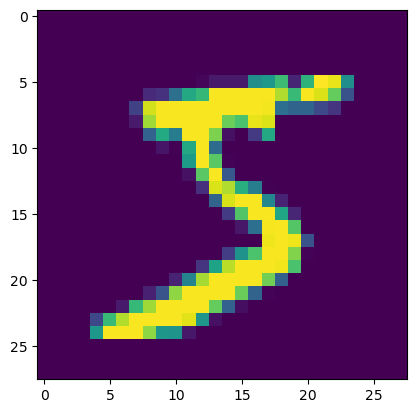

In [129]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [130]:
x_train=x_train.reshape(x_train.shape[0],-1)

In [131]:
y_train.shape,x_train.shape

((60000, 10), (60000, 784))

In [92]:
import torch
import torch.nn as nn
loss=nn.CrossEntropyLoss()

In [133]:
def data_iter_my(x, y, batch_size):
    num=len(x)
    indices=list(range(num))
    np.random.shuffle(indices)
    for i in range(0,num,batch_size):
        batch_indices=np.array(indices[i:i+batch_size])
        yield x[batch_indices],y[batch_indices]


In [145]:
epoch=50
batch_size=256
mnist=net_2(28*28,10,500,batch_size=batch_size,loss_fun='ce_softmaxloss',activate='relu')
for i in range(epoch):
    error1=0

    data=data_iter_my(x_train, y_train, batch_size=batch_size)
    for X,y in data:
        a=mnist.forward(X)
        mnist.backward(X,y)
        mnist.updater(0.1)
        error1+=ce_softmaxloss(a,y).sum()
        #算法差异和torch算的误差有出入，下降成功实现
    print(i,error1/x_train.shape[0])



0 1.3231472660734331
0 tensor(1.9027, dtype=torch.float64)
1 0.5934908572021874
1 tensor(1.7074, dtype=torch.float64)
2 0.4770632984662166
2 tensor(1.6626, dtype=torch.float64)
3 0.41901047154179855
3 tensor(1.6397, dtype=torch.float64)
4 0.38225053752416527
4 tensor(1.6254, dtype=torch.float64)
5 0.35571770291194177
5 tensor(1.6148, dtype=torch.float64)
6 0.3354427075693913
6 tensor(1.6072, dtype=torch.float64)
7 0.31910157892112756
7 tensor(1.6009, dtype=torch.float64)
8 0.3053129828656157
8 tensor(1.5959, dtype=torch.float64)
9 0.2934796780261991
9 tensor(1.5912, dtype=torch.float64)
10 0.2831038725699475
10 tensor(1.5874, dtype=torch.float64)
11 0.27409771820552853
11 tensor(1.5840, dtype=torch.float64)
12 0.2657987497046004
12 tensor(1.5810, dtype=torch.float64)
13 0.25841044349878417
13 tensor(1.5783, dtype=torch.float64)
14 0.25158704800969
14 tensor(1.5757, dtype=torch.float64)
15 0.24544947684192384
15 tensor(1.5734, dtype=torch.float64)
16 0.23957750860477547
16 tensor(1.5713

In [144]:
mnist.predict(x_train[0].reshape(1,28*28))

array([[9.18179655e-07, 8.00112673e-06, 8.41004707e-04, 1.87094580e-01,
        6.40946082e-09, 8.11972034e-01, 8.05154579e-08, 6.60582220e-05,
        6.18604646e-06, 1.11300849e-05]])